# k-means法

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

## k-means法の基礎

In [7]:
from sklearn.datasets.samples_generator import make_blobs

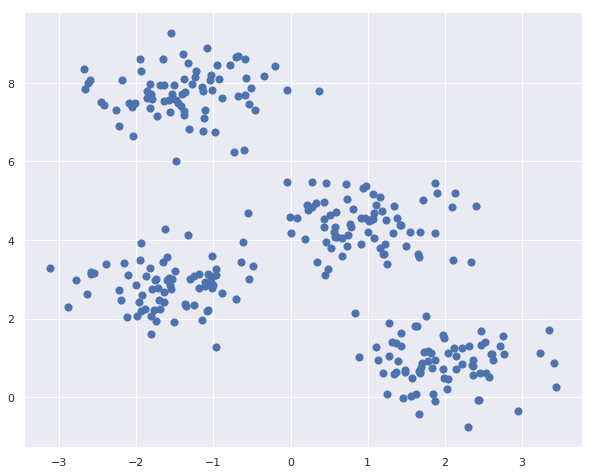

In [10]:
X, y_true = make_blobs(n_samples=300, centers=4,
                                          cluster_std=0.6, random_state=0)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=50)

In [11]:
from sklearn.cluster import KMeans

In [14]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

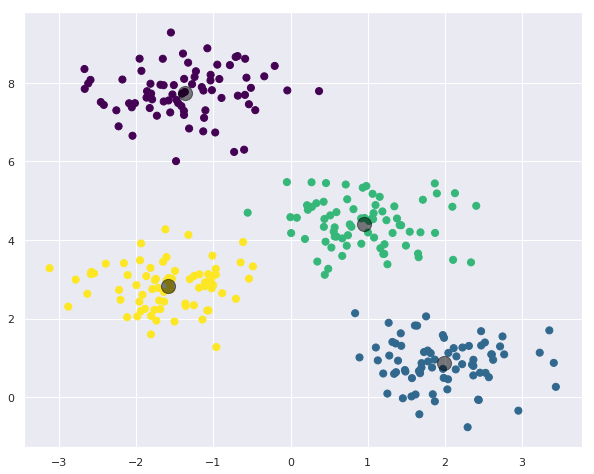

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers =kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## 期待値最大化法

In [24]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # ランダムにクラスタを選択
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 最近傍のクラスタでラベル付けをする
        labels = pairwise_distances_argmin(X, centers)
        
        # ポイントの平均lからクラスタの中心を決定する
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 収束しているか調べる
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

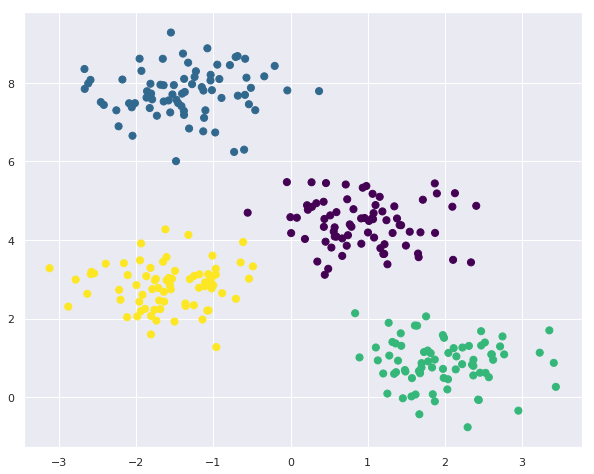

In [23]:
centers, labels = find_clusters(X, 4)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

## 期待値最大化法の注意点

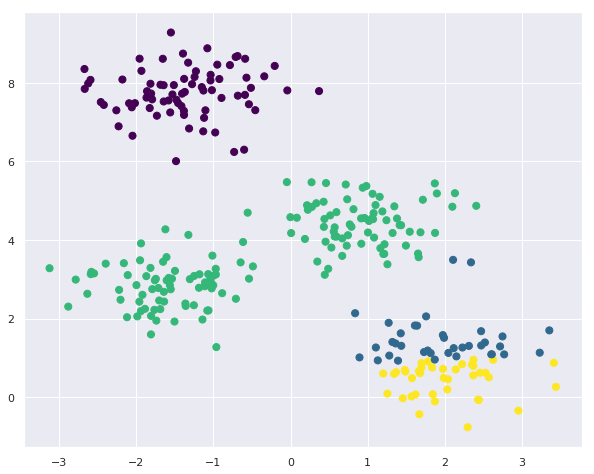

In [32]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

### クラスタ数をあらかじめ設定する必要がある

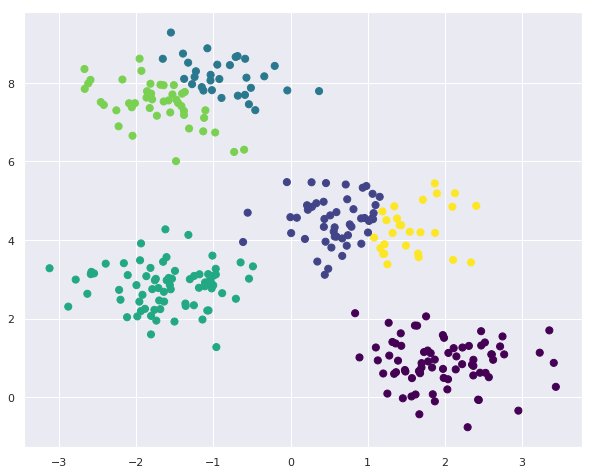

In [34]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

### k-meansは線形クラスタ境界に限定される

In [35]:
from sklearn.datasets import make_moons

In [38]:
X, y = make_moons(200, noise=.05, random_state=0)

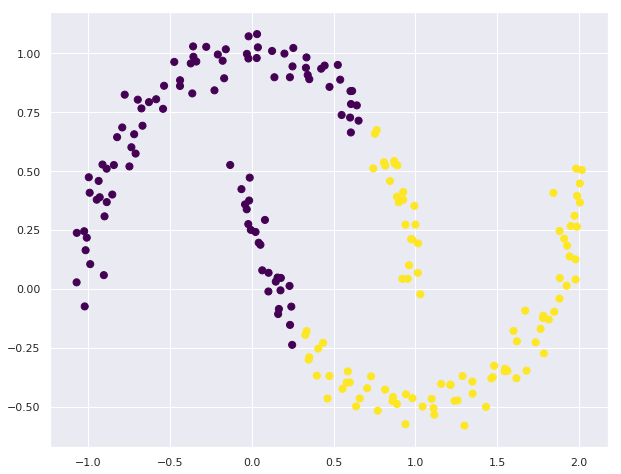

In [39]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

In [40]:
from sklearn.cluster import SpectralClustering

/Users/shimizukousuke/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


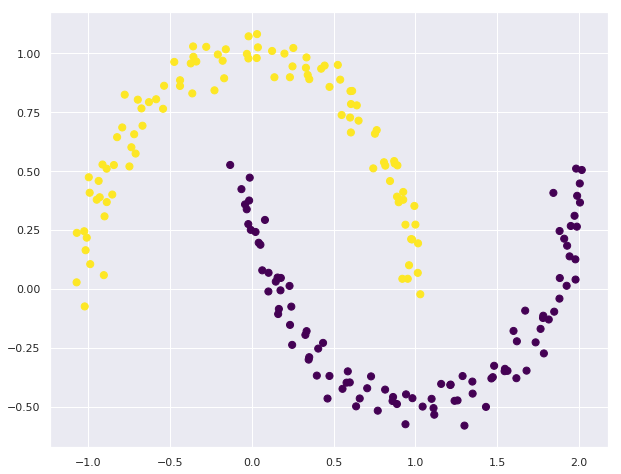

In [41]:
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

## 事例1:手書き数字

In [42]:
from sklearn.datasets import load_digits

In [43]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [44]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

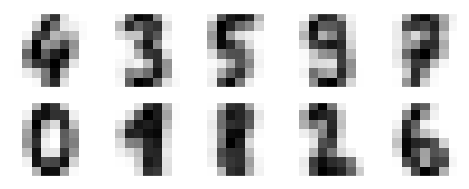

In [46]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [47]:
from scipy.stats import mode

In [49]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
accuracy_score(digits.target, labels)

0.7935447968836951

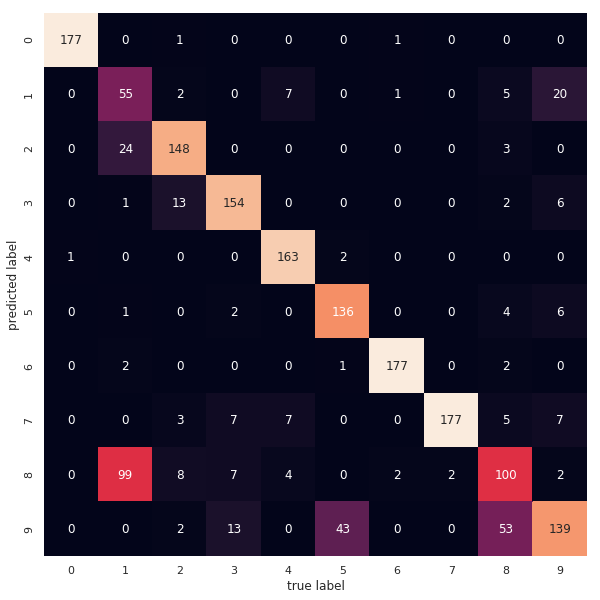

In [56]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [57]:
from sklearn.manifold import TSNE

In [58]:
tsne = TSNE(n_components=2, init='pca', random_state=-0)
digits_proj = tsne.fit_transform(digits.data)

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

accuracy_score(digits.target, labels)

0.9398998330550918

精度が上がった

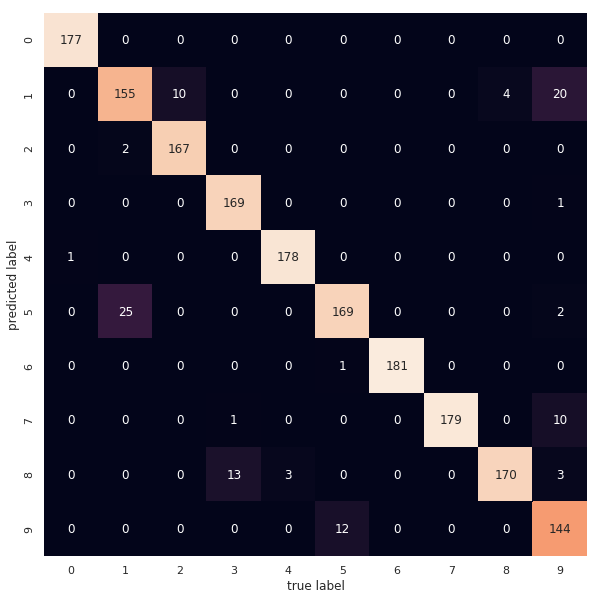

In [59]:
mat = confusion_matrix(digits.target, labels)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## 事例2:k-meansによるカラー圧縮

In [60]:
from sklearn.datasets import load_sample_image

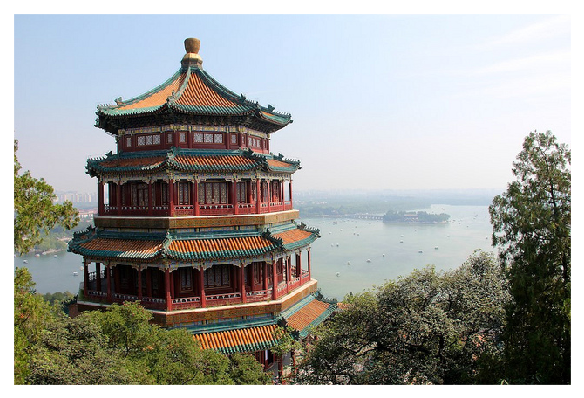

In [64]:
china = load_sample_image('china.jpg')
plt.figure(figsize=(10, 8))
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

In [65]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [70]:
def plot_pxiels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

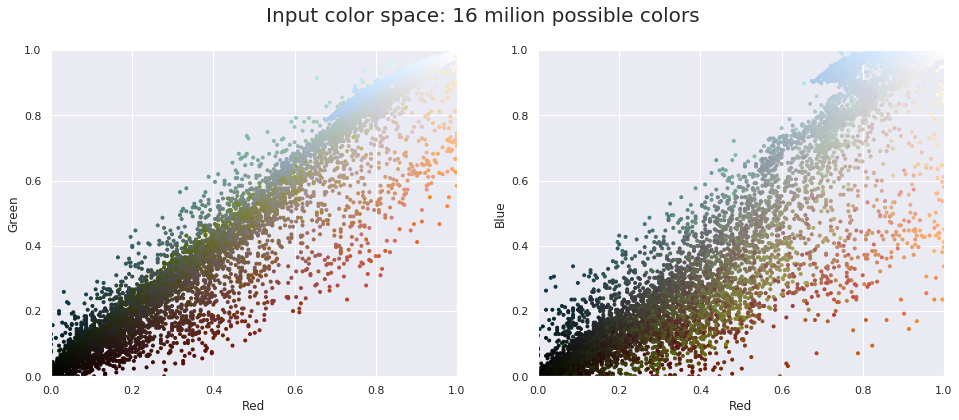

In [72]:
plot_pxiels(data, title='Input color space: 16 milion possible colors')

色を減らす

In [73]:
from sklearn.cluster import MiniBatchKMeans

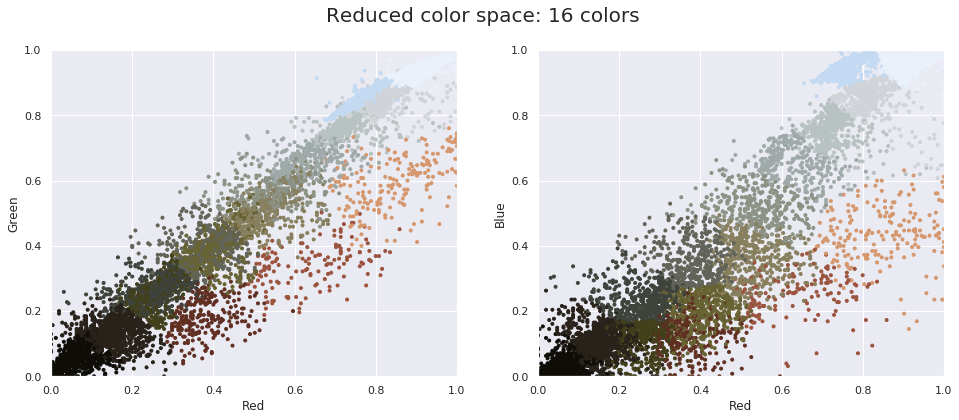

In [76]:
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pxiels(data, colors=new_colors, title='Reduced color space: 16 colors')

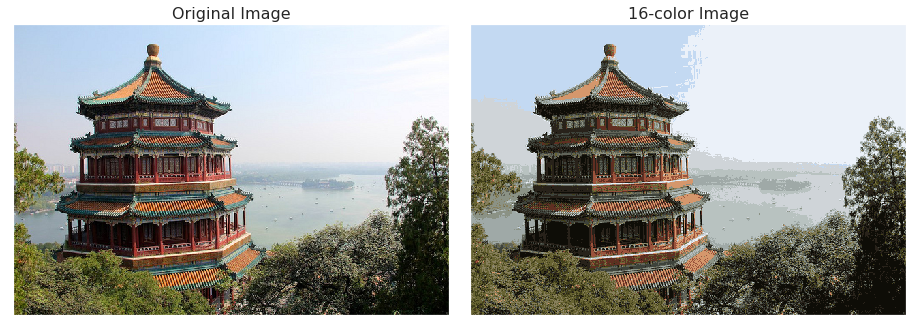

In [78]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);